In [97]:
import pandas as pd
import numpy as np
import matplotlib as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
%pylab inline
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [99]:
torch.cuda.is_available()

True

In [100]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [104]:
data = pd.read_csv("nasdaq100_padding.csv")

In [105]:
data.shape

(40560, 82)

In [106]:
data.head()

,AAL,AAPL,ADBE,ADI,ADP,ADSK,AKAM,ALXN,AMAT,AMGN,...,TXN,VIAB,VOD,VRTX,WBA,WDC,WFM,XLNX,YHOO,NDX
0,35.9800,96.80,97.80,61.15,95.4000,58.180000,58.00,127.040,26.680,165.8100,...,70.73,45.230,31.1701,95.270,81.365,52.16,33.95,48.61,38.010,4665.054
1,35.9310,96.89,97.80,61.61,95.4115,58.190000,58.12,126.060,26.730,165.9101,...,70.69,45.010,31.1900,94.170,81.540,52.15,34.10,48.74,38.140,4665.054
2,35.9044,96.95,97.57,61.98,95.5100,58.203333,57.95,126.510,26.712,166.1800,...,71.30,45.015,31.2100,94.749,81.530,52.27,34.01,48.99,38.150,4665.826
3,35.8900,96.97,97.55,62.09,95.5200,58.216667,57.96,126.280,26.740,166.1480,...,71.31,45.020,31.2100,94.310,81.710,52.30,33.96,48.95,38.195,4667.081
4,36.0080,96.96,97.73,61.89,95.5300,58.230000,58.21,126.585,26.720,165.9900,...,71.06,45.050,31.1800,94.155,81.720,52.30,34.17,48.89,38.320,4664.491


<AxesSubplot:>

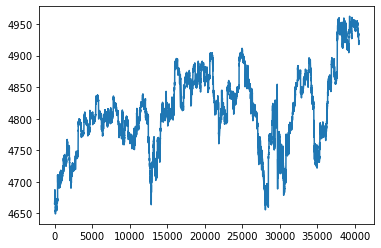

In [107]:
data["NDX"].plot()

In [108]:
batch_size = 128
timesteps = 16
n_timeseries = data.shape[1] - 1
train_length = 35100
val_length = 2730
test_length = 2730
target = "NDX"

In [109]:
X = np.zeros((len(data), timesteps, data.shape[1]-1))
y = np.zeros((len(data), timesteps, 1))

In [110]:
for i, name in enumerate(list(data.columns[:-1])):
    for j in range(timesteps):
        X[:, j, i] = data[name].shift(timesteps - j - 1).fillna(method="bfill")

In [111]:
for j in range(timesteps):
    y[:, j, 0] = data["NDX"].shift(timesteps - j - 1).fillna(method="bfill")

In [112]:
prediction_horizon = 1
target = data["NDX"].shift(-prediction_horizon).fillna(method="ffill").values

In [113]:
X = X[timesteps:]
y = y[timesteps:]
target = target[timesteps:]

In [114]:
X_train = X[:train_length]
y_his_train = y[:train_length]
X_val = X[train_length:train_length+val_length]
y_his_val = y[train_length:train_length+val_length]
X_test = X[-val_length:]
y_his_test = y[-val_length:]
target_train = target[:train_length]
target_val = target[train_length:train_length+val_length]
target_test = target[-val_length:]

In [115]:
X_train_max = X_train.max(axis=0)
X_train_min = X_train.min(axis=0)
y_his_train_max = y_his_train.max(axis=0)
y_his_train_min = y_his_train.min(axis=0)
target_train_max = target_train.max(axis=0)
target_train_min = target_train.min(axis=0)

In [116]:
X_train = (X_train - X_train_min) / (X_train_max - X_train_min)
X_val = (X_val - X_train_min) / (X_train_max - X_train_min)
X_test = (X_test - X_train_min) / (X_train_max - X_train_min)

y_his_train = (y_his_train - y_his_train_min) / (y_his_train_max - y_his_train_min)
y_his_val = (y_his_val - y_his_train_min) / (y_his_train_max - y_his_train_min)
y_his_test = (y_his_test - y_his_train_min) / (y_his_train_max - y_his_train_min)


target_train = (target_train - target_train_min) / (target_train_max - target_train_min)
target_val = (target_val - target_train_min) / (target_train_max - target_train_min)
target_test = (target_test - target_train_min) / (target_train_max - target_train_min)

In [117]:
X_train.shape, y_his_train.shape, target_train.shape

((35100, 16, 81), (35100, 16, 1), (35100,))

In [ ]:
X_train_t = torch.Tensor(X_train).cuda()
X_val_t = torch.Tensor(X_val).cuda()
X_test_t = torch.Tensor(X_test).cuda()
y_his_train_t = torch.Tensor(y_his_train).cuda()
y_his_val_t = torch.Tensor(y_his_val).cuda()
y_his_test_t = torch.Tensor(y_his_test).cuda()
target_train_t = torch.Tensor(target_train).cuda()
target_val_t = torch.Tensor(target_val).cuda()
target_test_t = torch.Tensor(target_test).cuda()

In [ ]:
data_train_loader = DataLoader(TensorDataset(X_train_t, y_his_train_t, target_train_t), shuffle=True, batch_size=128)
data_val_loader = DataLoader(TensorDataset(X_val_t, y_his_val_t, target_val_t), shuffle=False, batch_size=128)
data_test_loader = DataLoader(TensorDataset(X_test_t, y_his_test_t, target_test_t), shuffle=False, batch_size=128)

### DARNN

In [ ]:
class InputAttentionEncoder(nn.Module):
    def __init__(self, N, M, T, stateful=False):
        """
        :param: N: int
            number of time serieses
        :param: M:
            number of LSTM units
        :param: T:
            number of timesteps
        :param: stateful:
            decides whether to initialize cell state of new time window with values of the last cell state
            of previous time window or to initialize it with zeros
        """
        super(self.__class__, self).__init__()
        self.N = N
        self.M = M
        self.T = T
        
        self.encoder_lstm = nn.LSTMCell(input_size=self.N, hidden_size=self.M)
        
        #equation 8 matrices
        
        self.W_e = nn.Linear(2*self.M, self.T)
        self.U_e = nn.Linear(self.T, self.T, bias=False)
        # self.v_e = nn.Linear(self.T, 1, bias=False)
    
    def forward(self, inputs):
        encoded_inputs = torch.zeros((inputs.size(0), self.T, self.M)).cuda()
        
        #initiale hidden states
        h_tm1 = torch.zeros((inputs.size(0), self.M)).cuda()
        s_tm1 = torch.zeros((inputs.size(0), self.M)).cuda()
        
        for t in range(self.T):
            #concatenate hidden states
            h_c_concat = torch.cat((h_tm1, s_tm1), dim=1)
            
            #attention weights for each k in N (equation 8)
            x = self.W_e(h_c_concat).unsqueeze_(1).repeat(1, self.N, 1)
            y = self.U_e(inputs.permute(0, 2, 1))
            
            e_k_t = torch.sum(x * y, dim=-1)

            #normalize attention weights (equation 9)
            alpha_k_t = F.softmax(e_k_t, dim=1)
            
            #weight inputs (equation 10)
            weighted_inputs = alpha_k_t * inputs[:, t, :] 
    
            #calculate next hidden states (equation 11)
            h_tm1, s_tm1 = self.encoder_lstm(weighted_inputs, (h_tm1, s_tm1))
            
            encoded_inputs[:, t, :] = h_tm1
        return encoded_inputs

In [118]:
class TemporalAttentionDecoder(nn.Module):
    def __init__(self, M, P, T, stateful=False):
        """
        :param: M: int
            number of encoder LSTM units
        :param: P:
            number of deocder LSTM units
        :param: T:
            number of timesteps
        :param: stateful:
            decides whether to initialize cell state of new time window with values of the last cell state
            of previous time window or to initialize it with zeros
        """
        super(self.__class__, self).__init__()
        self.M = M
        self.P = P
        self.T = T
        self.stateful = stateful
        
        self.decoder_lstm = nn.LSTMCell(input_size=1, hidden_size=self.P)
        
        #equation 12 matrices
        self.W_d = nn.Linear(2*self.P, self.M)
        self.U_d = nn.Linear(self.M, self.M, bias=False)
        self.v_d = nn.Linear(self.M, 1, bias = False)
        
        #equation 15 matrix
        self.w_tilda = nn.Linear(self.M + 1, 1)
        
        #equation 22 matrices
        self.W_y = nn.Linear(self.P + self.M, self.P)
        self.v_y = nn.Linear(self.P, 1)
        
    def forward(self, encoded_inputs, y):
        
        #initializing hidden states
        d_tm1 = torch.zeros((encoded_inputs.size(0), self.P)).cuda()
        s_prime_tm1 = torch.zeros((encoded_inputs.size(0), self.P)).cuda()
        for t in range(self.T):
            #concatenate hidden states
            d_s_prime_concat = torch.cat((d_tm1, s_prime_tm1), dim=1)
            #print(d_s_prime_concat)
            #temporal attention weights (equation 12)
            x1 = self.W_d(d_s_prime_concat).unsqueeze_(1).repeat(1, encoded_inputs.shape[1], 1)
            y1 = self.U_d(encoded_inputs)
            z1 = torch.tanh(x1 + y1)
            l_i_t = self.v_d(z1)
            
            #normalized attention weights (equation 13)
            beta_i_t = F.softmax(l_i_t, dim=1)
            
            #create context vector (equation_14)
            c_t = torch.sum(beta_i_t * encoded_inputs, dim=1)
            
            #concatenate c_t and y_t
            y_c_concat = torch.cat((c_t, y[:, t, :]), dim=1)
            #create y_tilda
            y_tilda_t = self.w_tilda(y_c_concat)
            
            #calculate next hidden states (equation 16)
            d_tm1, s_prime_tm1 = self.decoder_lstm(y_tilda_t, (d_tm1, s_prime_tm1))
        
        #concatenate context vector at step T and hidden state at step T
        d_c_concat = torch.cat((d_tm1, c_t), dim=1)

        #calculate output
        y_Tp1 = self.v_y(self.W_y(d_c_concat))
        return y_Tp1

In [ ]:
class DARNN(nn.Module):
    def __init__(self, N, M, P, T, stateful_encoder=False, stateful_decoder=False):
        super(self.__class__, self).__init__()
        self.encoder = InputAttentionEncoder(N, M, T, stateful_encoder).cuda()
        self.decoder = TemporalAttentionDecoder(M, P, T, stateful_decoder).cuda()
    def forward(self, X_history, y_history):
        out = self.decoder(self.encoder(X_history), y_history)
        return out

In [119]:
model = DARNN(X_train.shape[2], 64, 64, X_train.shape[1]).cuda()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
epoch_scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.9)

Saving...
Iter:  0 train:  0.14953661083919326 val:  0.1428847819977677
mse:  1405.1548 mae:  28.737288


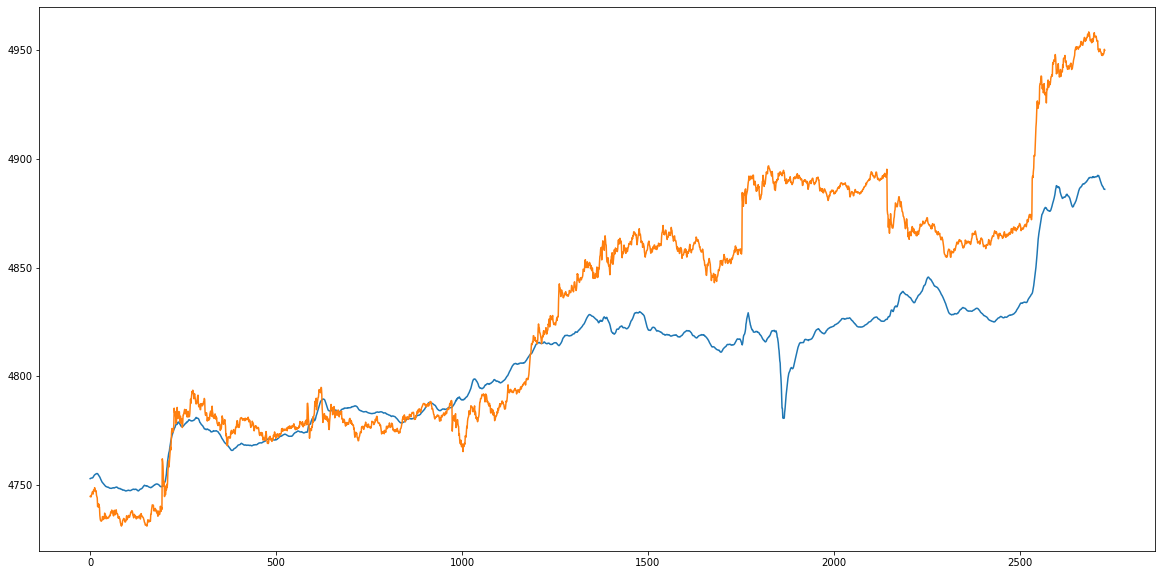

Saving...
Iter:  1 train:  0.03644505414312342 val:  0.07948014714148476
Iter:  2 train:  0.031208252810734086 val:  0.08792006410627384
Saving...
Iter:  3 train:  0.028322470207129285 val:  0.06979877226928999
Iter:  4 train:  0.027644650349262972 val:  0.07661234297387784
Saving...
Iter:  5 train:  0.02492120868833095 val:  0.061288215924843015
Saving...
Iter:  6 train:  0.02213626608892754 val:  0.03479050715342211
Saving...
Iter:  7 train:  0.019384019494987317 val:  0.0298570929466482
Saving...
Iter:  8 train:  0.017573116269809314 val:  0.025863384541566073
Saving...
Iter:  9 train:  0.01552140210971699 val:  0.017839533128379076
Iter:  10 train:  0.01467419124584058 val:  0.0223837270773539
mse:  34.48399 mae:  5.022996


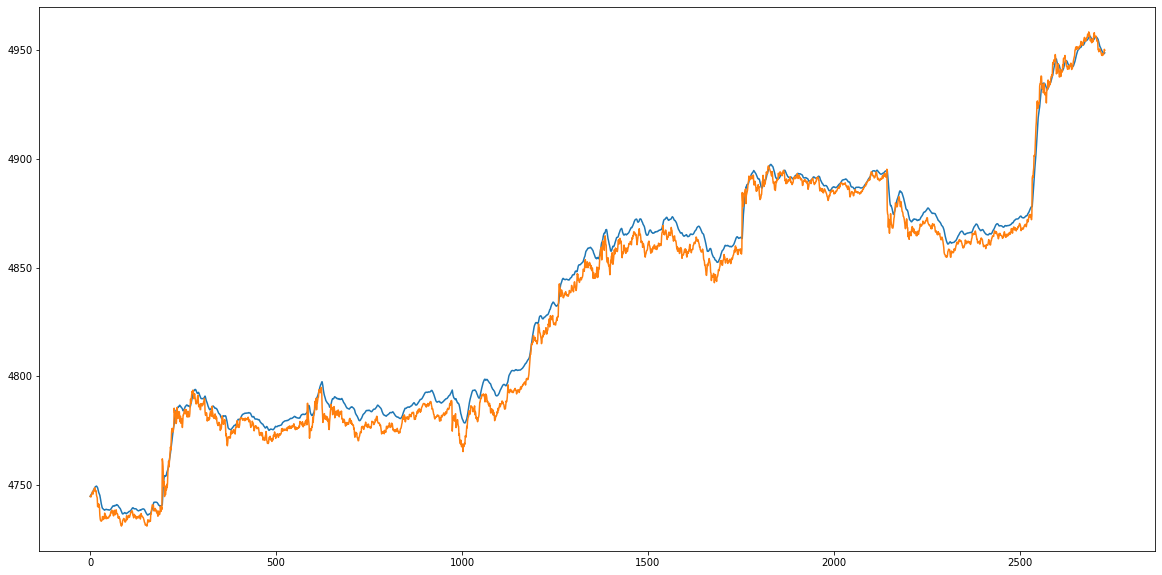

Saving...
Iter:  11 train:  0.013148544334645396 val:  0.01471658872445546
Saving...
Iter:  12 train:  0.012054438622678135 val:  0.01239437587901118
Iter:  13 train:  0.01119884620152958 val:  0.013486531110247158
Saving...
Iter:  14 train:  0.010615236146272638 val:  0.010613288579913175
Saving...
Iter:  15 train:  0.010151562551020728 val:  0.010472428029472994
Saving...
Iter:  16 train:  0.009916299450574867 val:  0.009217090815018874
Iter:  17 train:  0.009541990827119078 val:  0.009642678046756685
Saving...
Iter:  18 train:  0.009095629441678334 val:  0.00902459918569935
Saving...
Iter:  19 train:  0.008959279802073875 val:  0.008427367699743027
Saving...
Iter:  20 train:  0.009015814798799246 val:  0.008316468123477657
mse:  4.760261 mae:  1.5111111


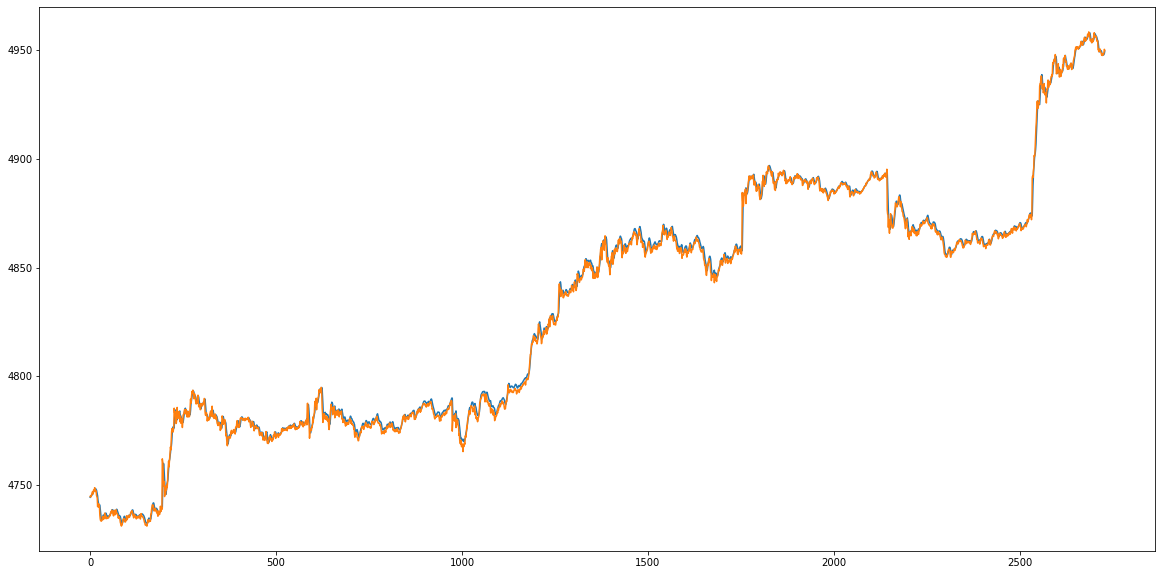

Iter:  21 train:  0.008600910047174695 val:  0.008391907554727338
Iter:  22 train:  0.008222132575782184 val:  0.009126007234082786
Saving...
Iter:  23 train:  0.008803720241404028 val:  0.008067108201701569
Iter:  24 train:  0.008176638192787336 val:  0.008158396245055387
Iter:  25 train:  0.008071364631636893 val:  0.011501590309978346
Saving...
Iter:  26 train:  0.007807185533470614 val:  0.007131085224642333
Iter:  27 train:  0.008160078426295849 val:  0.007774237169519639
Saving...
Iter:  28 train:  0.007736512221267619 val:  0.0066300948517064
Iter:  29 train:  0.007541342532699711 val:  0.008845296208416691
Iter:  30 train:  0.007481591545425112 val:  0.008129375896610575
mse:  4.5484548 mae:  1.6020604


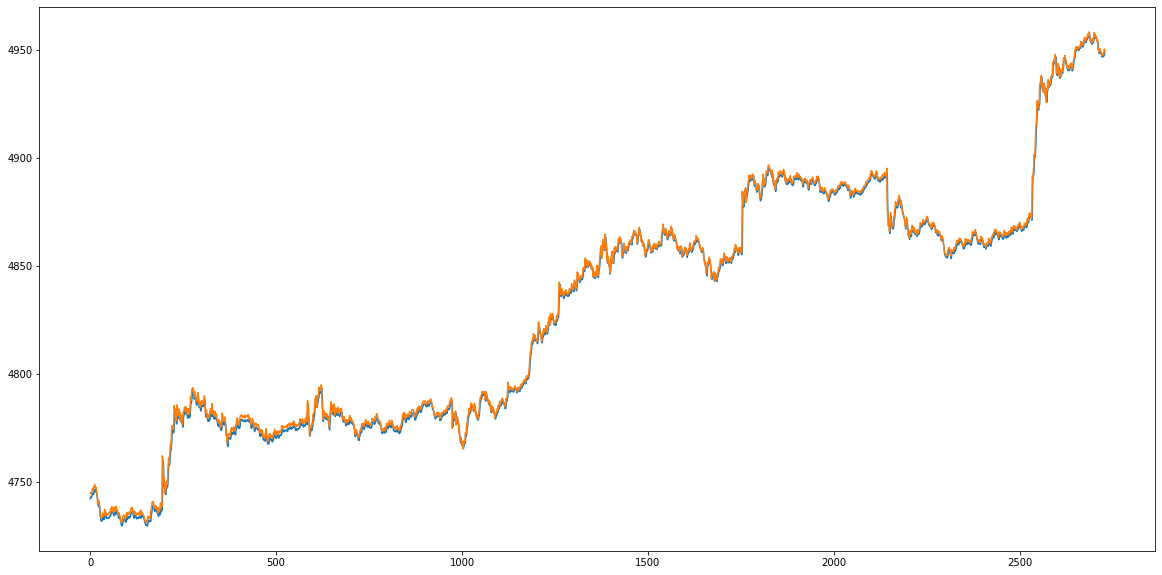

Iter:  31 train:  0.007301587188404795 val:  0.007292788545349786
Iter:  32 train:  0.007497144156856452 val:  0.00933923328460118
Saving...
Iter:  33 train:  0.00719836329024477 val:  0.006323242349015123
Saving...
Iter:  34 train:  0.007301080433239488 val:  0.0062228916787726496
Iter:  35 train:  0.007056017706746559 val:  0.006528472458041799
Saving...
Iter:  36 train:  0.007058586649920155 val:  0.006170658777517458
Iter:  37 train:  0.007238126058392181 val:  0.006191568962448497
Iter:  38 train:  0.007145699379223838 val:  0.0073033391067245865
Iter:  39 train:  0.0071401796469646155 val:  0.006799642871809247
Iter:  40 train:  0.006938029227409454 val:  0.006497857291884411
mse:  2.905984 mae:  1.1166868


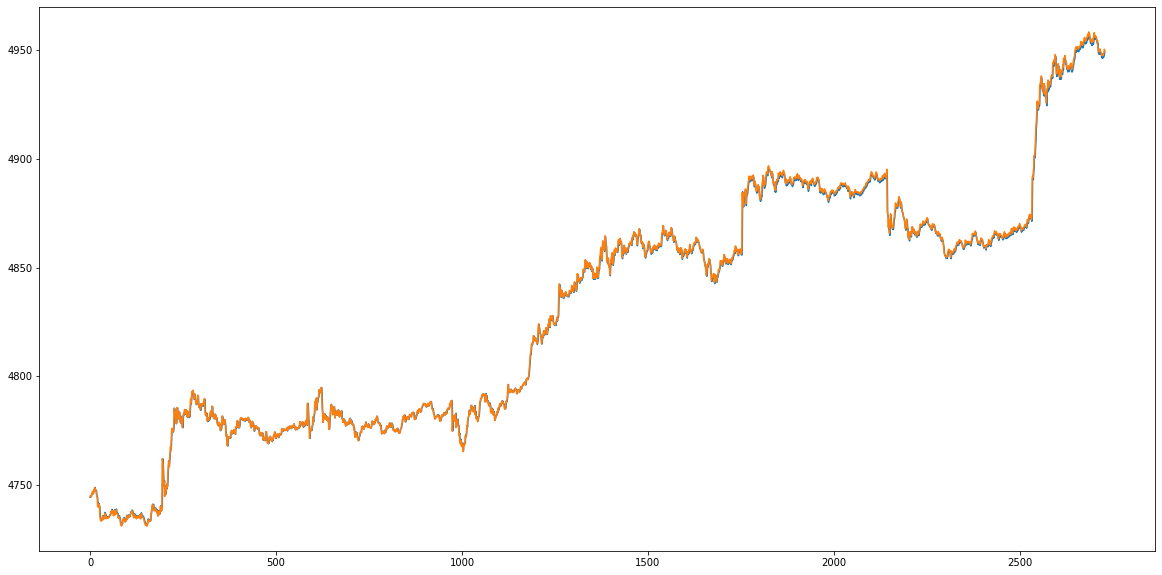

Saving...
Iter:  41 train:  0.006962735290591424 val:  0.006138520778408364
Iter:  42 train:  0.007071088443227169 val:  0.006234745997975007
Iter:  43 train:  0.006981976788871627 val:  0.007509137387725692
Iter:  44 train:  0.006905345438583537 val:  0.013300618759473836
Iter:  45 train:  0.007323115310455958 val:  0.006783826749655902
Iter:  46 train:  0.006879529365667575 val:  0.006167763753738564
Iter:  47 train:  0.006974292138997232 val:  0.00640629361333575
Iter:  48 train:  0.007112418666928787 val:  0.0066924186792156615
Iter:  49 train:  0.007012738181449364 val:  0.006195829269041589
Iter:  50 train:  0.006896613500113075 val:  0.006838998516916007
mse:  3.219118 mae:  1.2183045


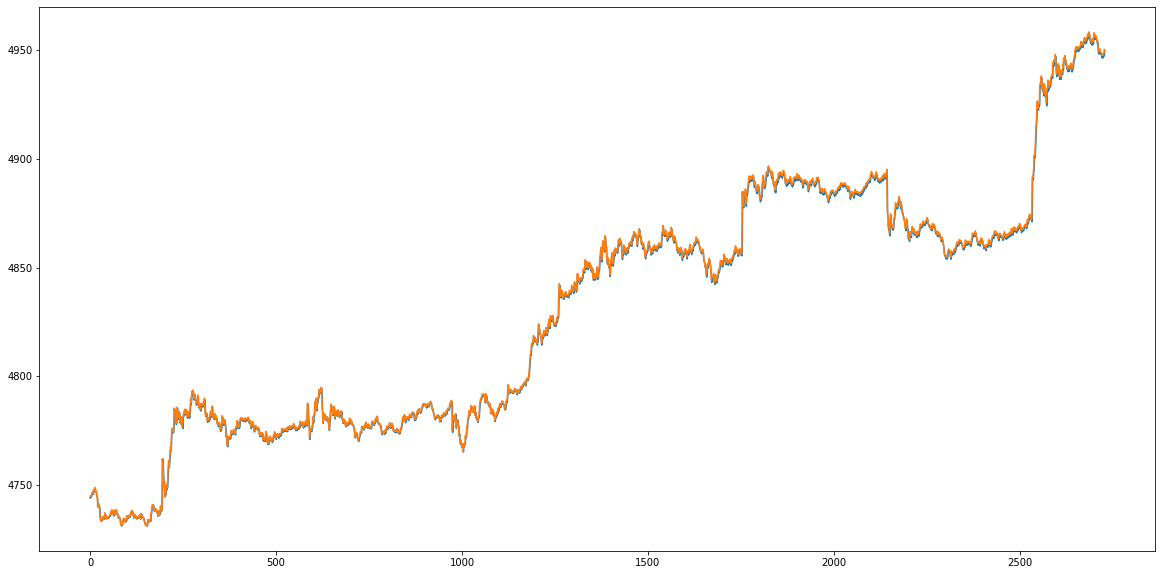

In [123]:
epochs = 51
loss = nn.MSELoss()
patience = 15
min_val_loss = 9999
counter = 0
for i in range(epochs):
    mse_train = 0
    for batch_x, batch_y_h, batch_y in data_train_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        batch_y_h = batch_y_h.cuda()
        opt.zero_grad()
        y_pred = model(batch_x, batch_y_h)
        y_pred = y_pred.squeeze(1)
        l = loss(y_pred, batch_y)
        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        opt.step()
    epoch_scheduler.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y_h, batch_y in data_val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            batch_y_h = batch_y_h.cuda()
            output = model(batch_x, batch_y_h)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += loss(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    
    if min_val_loss > mse_val**0.5:
        min_val_loss = mse_val**0.5
        print("Saving...")
        torch.save(model.state_dict(), "darnn_nasdaq.pt")
        counter = 0
    else: 
        counter += 1
    
    if counter == patience:
        break
    print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, "val: ", (mse_val/len(X_val_t))**0.5)
    if(i % 10 == 0):
        preds = preds*(target_train_max - target_train_min) + target_train_min
        true = true*(target_train_max - target_train_min) + target_train_min
        mse = mean_squared_error(true, preds)
        mae = mean_absolute_error(true, preds)
        print("mse: ", mse, "mae: ", mae)
        plt.figure(figsize=(20, 10))
        plt.plot(preds)
        plt.plot(true)
        plt.show()

In [124]:
model.load_state_dict(torch.load("darnn_nasdaq.pt"))

<All keys matched successfully>

In [125]:
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    for batch_x, batch_y_h, batch_y in data_test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        batch_y_h = batch_y_h.cuda()
        output = model(batch_x, batch_y_h)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
        mse_val += loss(output, batch_y).item()*batch_x.shape[0]
preds = np.concatenate(preds)
true = np.concatenate(true)

C:\Users\SAANKHYA\anaconda3\envs\pytorch_env\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\SAANKHYA\anaconda3\envs\pytorch_env\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([42])) that is different to the input size (torch.Size([42, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [126]:
preds = preds*(target_train_max - target_train_min) + target_train_min
true = true*(target_train_max - target_train_min) + target_train_min

In [127]:
mse = mean_squared_error(true, preds)
mae = mean_absolute_error(true, preds)

In [128]:
mse, mae

(2.0060189, 0.9052044)

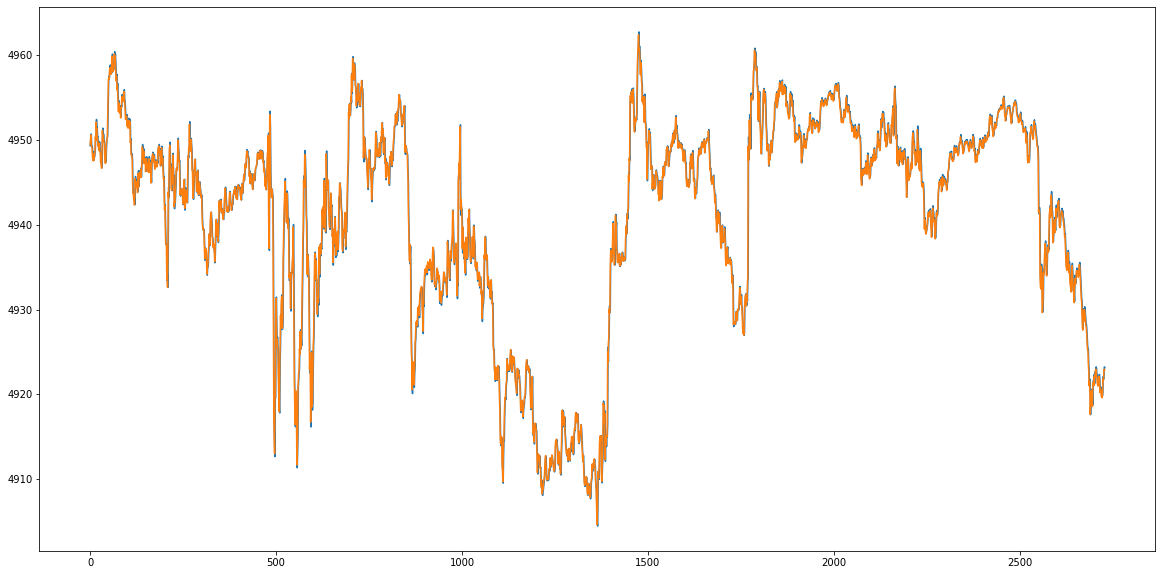

In [129]:
plt.figure(figsize=(20, 10))
plt.plot(preds)
plt.plot(true)
plt.show()